/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc
int
232
2020-02-09T00:00:00.000000000


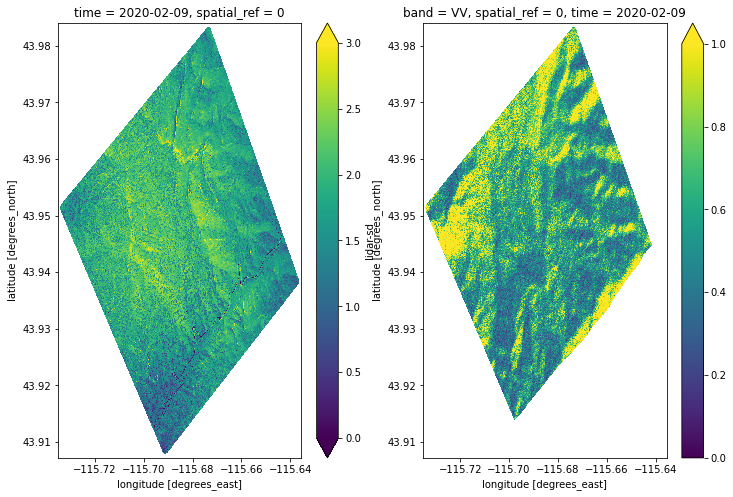

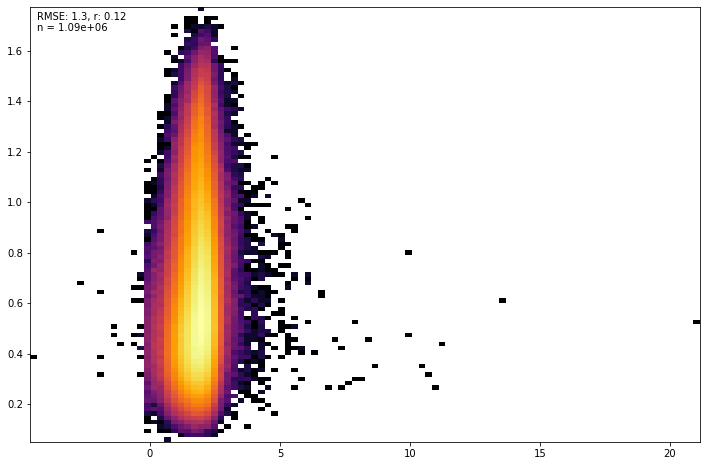

2021-03-15T00:00:00.000000000


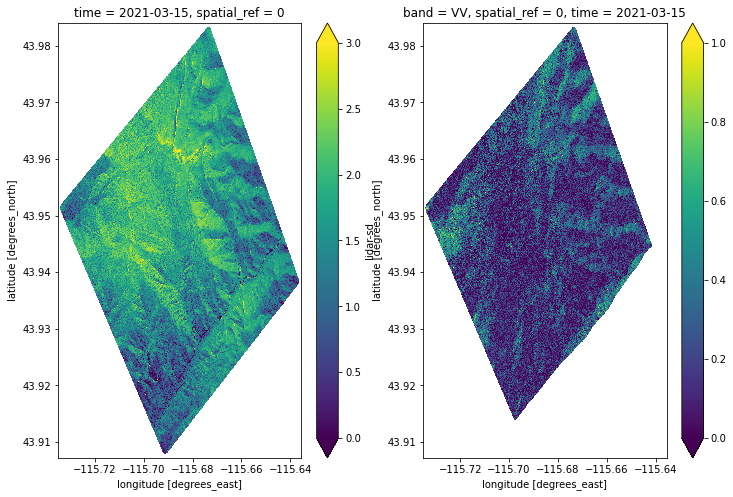

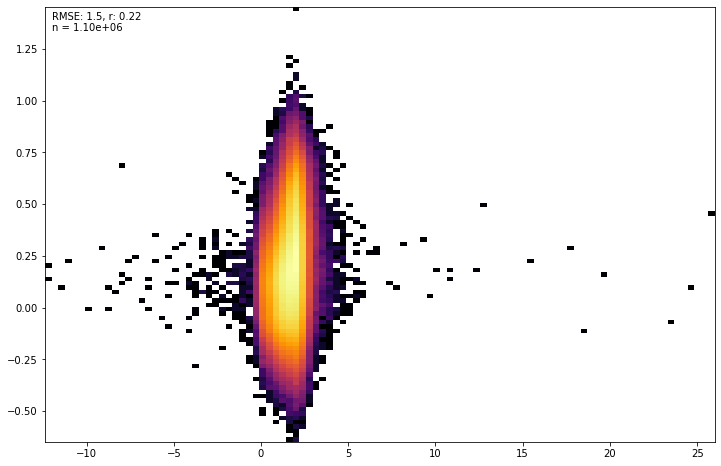

052
2020-02-09T00:00:00.000000000
2021-03-15T00:00:00.000000000


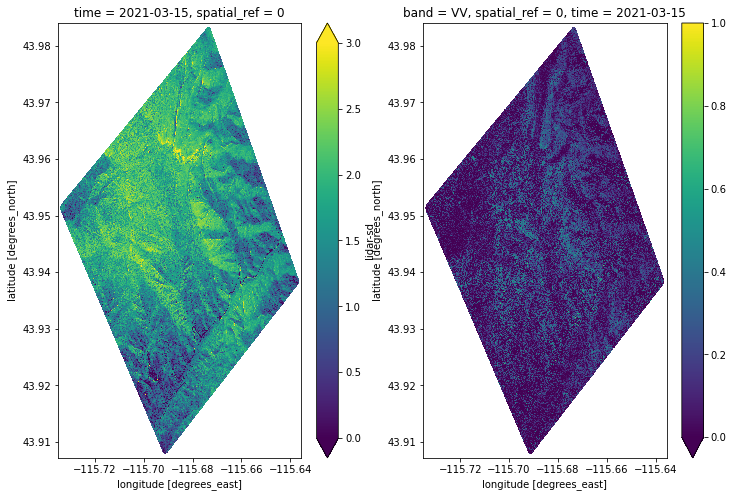

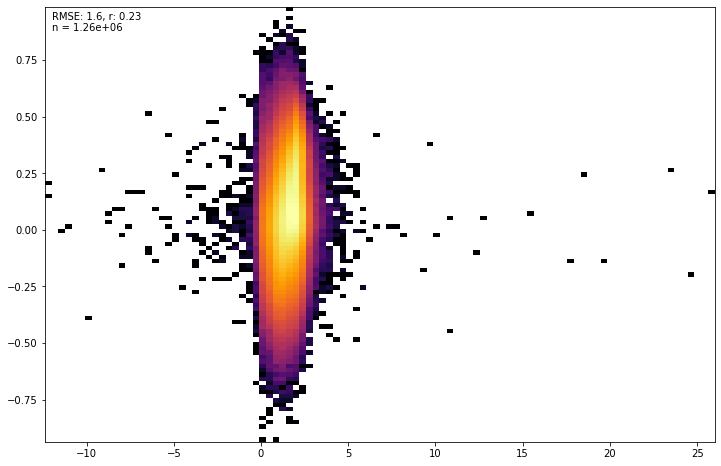

unw
232
2020-02-09T00:00:00.000000000


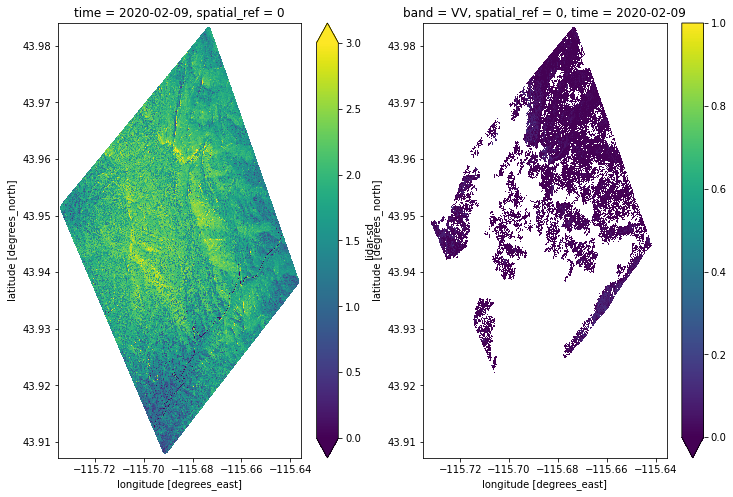

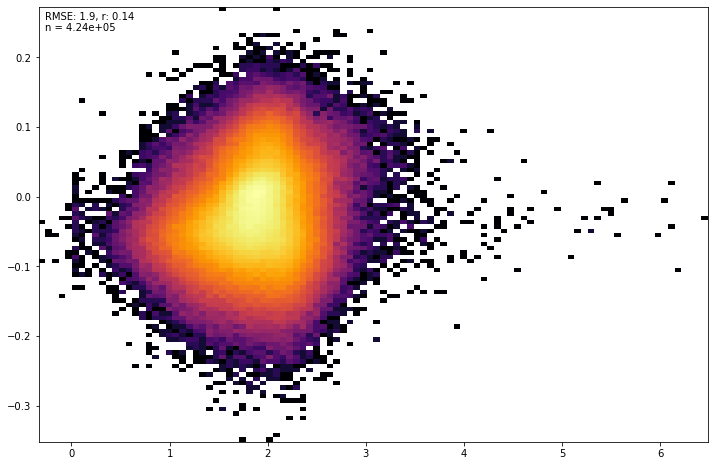

2021-03-15T00:00:00.000000000


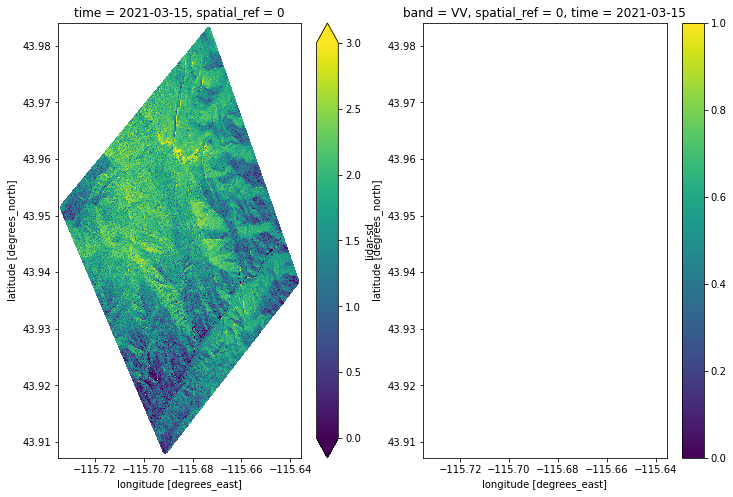

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

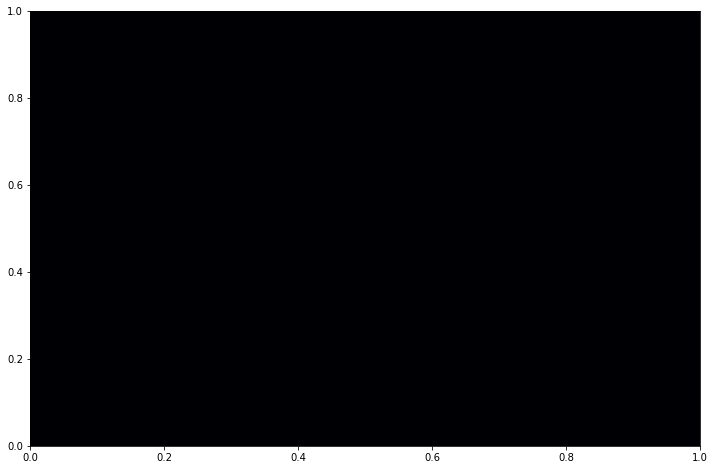

In [62]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import pandas as pd

# loop through each flight pair and calculate rmse, r2, plot

lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')

for lidar_fp in lidar_dir.glob('*.sd.nc'):
    lidar = xr.open_dataset(lidar_fp)
    print(lidar_fp)

    for img_type in ['int', 'unw']:
        print(img_type)
        for direction in ['232', '052']:
            print(direction)
            for t in lidar.time:
                print(t.data)
                year = pd.to_datetime(t.data).year
                if year == 2020:
                    vars_dir = sorted([var for var in lidar.data_vars if direction in var])
                    uavsar_var = [var for var in vars_dir if '2020-' in var or '2019-' in var]
                    type_var = [var for var in uavsar_var if img_type in var]
                elif year == 2021:
                    vars_dir = sorted([var for var in lidar.data_vars if direction in var])
                    uavsar_var = [var for var in vars_dir if '2021-' in var]
                    type_var = [var for var in uavsar_var if img_type in var]

                if len(type_var) == 0:
                    continue

                fig, axes = plt.subplots(1, 2, figsize = (12,8))
                dss = []
                for var in type_var:
                    if len(dss) == 0:
                        dss = lidar[var]
                    else:
                        dss = dss + lidar[var]
                
                if len(dss) == 0:
                    continue
                
                lidar['lidar-sd'].sel(time = t).plot(vmax = 3, vmin = 0, ax = axes[0])
                dss.sel(band = 'VV').where(~lidar['lidar-sd'].sel(time = t).isnull()).plot(vmax = 1 , vmin = 0, ax = axes[1])
                plt.show()

                fig, ax = plt.subplots(1,1, figsize = (12,8))

                xs = lidar['lidar-sd'].sel(time = t).values.ravel()
                ys = dss.sel(band = 'VV').where(~lidar['lidar-sd'].sel(time = t).isnull()).values.ravel()

                xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys))]
                ys = ys[(~np.isnan(xs)) & (~np.isnan(ys))]
                xs = xs_tmp

                ax.hist2d(xs_tmp, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
                from sklearn.metrics import mean_squared_error
                rms = mean_squared_error(xs, ys, squared=False)

                from scipy.stats import pearsonr
                r, p = pearsonr(xs, ys)
                ax.text(.01, .99, f'RMSE: {rms:.2}, r: {r:.2}\nn = {len(ys):.2e}', ha='left', va='top', transform=ax.transAxes)
                plt.show()